In [196]:
#load aiida environment and connect to database
from aiida import load_profile
from aiida.orm import computers
profile = load_profile()
print('profile name : ',profile.name)
print('profile database host name : ',profile.database_hostname)
print('default user : ',profile.default_user)

profile name :  default
profile database host name :  localhost
default user :  r.mozumder@fz-juelich.de


In [197]:
from aiida.orm import load_group, load_node, WorkChainNode
from aiida_kkr.workflows import combine_imps_wc

In [198]:
from ImpurityDataExtraction.ImpData import MultiImpuritiesData
import pandas as pd
import numpy as np


In [199]:
node_group_3_3_1 = list(load_group(102).nodes)
node_group_3_3_2 = list(load_group(115).nodes)
node_group_3_4_1 = list(load_group(104).nodes)
node_group_3_4_2 = list(load_group(118).nodes)
node_group_3_3_3 = list(load_group(125).nodes)
node_group_3_3_4 = list(load_group(128).nodes)
node_group_3_3_5 = list(load_group(131).nodes)
node_group_3_4_3 = list(load_group(134).nodes)
node_group_3_4_4 = list(load_group(137).nodes)
node_group_3_4_5 = list(load_group(140).nodes)

In [200]:
#imp_data_dict = MultiImpuritiesData.ExtractDictMultipleNode(node_group_3_3_1)
#imp_data_dict.AppendDataMultipleNode(node_group_3_3_1)
#imp_data_dict.AppendDataMultipleNode(node_group_3_3_2)
#imp_data_dict.AppendDataMultipleNode(node_group_3_3_3)
#imp_data_dict.AppendDataMultipleNode(node_group_3_3_4)
#imp_data_dict.AppendDataMultipleNode(node_group_3_3_5)

#imp_data_dict.AppendDataMultipleNode(node_group_3_4_1)
#imp_data_dict.AppendDataMultipleNode(node_group_3_4_2)
#imp_data_dict.AppendDataMultipleNode(node_group_3_4_3)
#imp_data_dict.AppendDataMultipleNode(node_group_3_4_4)
#imp_data_dict.AppendDataMultipleNode(node_group_3_4_5)



#pd_data = pd.DataFrame(imp_data_dict.GetDataDict())
#pd_data.to_csv('d_block_magnetic_data.csv', index=False)


In [201]:
pd_data = pd.read_csv('d_block_magnetic_data.csv')

In [202]:
pd_data

,imp0,offset0,ilayer0,imp1,offset1,ilayer1,i,j,Z_i,Z_j,...,Dx,Dy,Dz,rx,ry,rz,r,mom1,mom2,tot_mom
0,21,0,3,22,1,3,0,1,21,22,...,-3.343143e-04,-2.023023e-03,-2.125044e-03,-0.418515,0.000000,0.000000,0.418515,1.856702e-06,8.152756e-01,8.152775e-01
1,21,0,3,21,1,3,0,1,21,21,...,-1.103540e-22,9.714628e-22,9.783230e-22,-0.418515,0.000000,0.000000,0.418515,-4.285949e-11,-4.675482e-11,-8.961432e-11
2,21,0,3,22,1,3,0,1,21,22,...,-3.343143e-04,-2.023023e-03,-2.125044e-03,-0.418515,0.000000,0.000000,0.418515,1.856702e-06,8.152756e-01,8.152775e-01
3,21,0,3,23,1,3,0,1,21,23,...,1.105447e-04,-1.627530e-02,-1.691822e-02,-0.418515,0.000000,0.000000,0.418515,3.455079e-03,2.646380e+00,2.649836e+00
4,21,0,3,24,1,3,0,1,21,24,...,1.342031e-04,-2.021058e-02,-1.622051e-02,-0.418515,0.000000,0.000000,0.418515,4.131726e-03,3.815013e+00,3.819145e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2075,24,0,3,24,5,4,0,1,24,24,...,-1.002226e-01,2.679457e-01,-8.234750e-01,-1.046287,-0.120815,-0.388147,1.122485,3.800159e+00,3.826078e+00,7.626237e+00
2076,24,0,3,23,5,4,0,1,24,23,...,-5.948181e-03,9.802852e-01,-5.151470e-02,-1.046287,-0.120815,-0.388147,1.122485,3.797582e+00,2.652779e+00,6.450361e+00
2077,24,0,3,42,5,4,0,1,24,42,...,1.100959e+00,5.793535e-01,3.041381e-01,-1.046287,-0.120815,-0.388147,1.122485,3.799005e+00,2.573782e+00,6.372787e+00
2078,25,0,3,25,5,4,0,1,25,25,...,-1.125688e-01,-5.540111e-02,3.339223e-01,-1.046287,-0.120815,-0.388147,1.122485,4.409713e+00,4.429645e+00,8.839358e+00


In [205]:
imp_atom = (24, 25)
ils = ()
header = list(pd_data.columns)
z_J_r = pd_data[header[1:3] + header[4:6] + header[8:10] + [header[10]] + [header[18]]]
J_Cr_V = z_J_r.loc[(z_J_r['Z_i']==imp_atom[0]) & (z_J_r['Z_j']==imp_atom[1]) & (z_J_r['ilayer0'].isin([3,4])) & (z_J_r['ilayer1']).isin([3,4])]
np.array(J_Cr_V.drop_duplicates().loc[:, ['r', 'J']])


array([[0.41851489, 4.7726718 ],
       [0.83702979, 1.82424207],
       [1.        , 1.82424209],
       [1.16202815, 1.82424209],
       [1.25554468, 1.82424209],
       [0.58222112, 0.67482266],
       [0.71703288, 2.38938647],
       [0.74789889, 2.38938649],
       [1.01960791, 2.38938649],
       [1.12248457, 2.38938649]])

In [207]:
J_Cr_V

,offset0,ilayer0,offset1,ilayer1,Z_i,Z_j,J,r
59,0,3,1,3,24,25,4.772672,0.418515
460,0,3,1,3,24,25,4.772672,0.418515
866,0,3,2,3,24,25,1.824242,0.837030
1208,0,3,3,3,24,25,1.824242,1.000000
1223,0,3,4,3,24,25,1.824242,1.162028
1233,0,3,5,3,24,25,1.824242,1.255545
1299,0,3,1,3,24,25,0.674823,0.582221
1700,0,3,2,3,24,25,2.389386,0.717033
2042,0,3,3,4,24,25,2.389386,0.747899
2058,0,3,4,4,24,25,2.389386,1.019608


In [195]:
pd_data.iloc[[1299,1700]]

,imp0,offset0,ilayer0,imp1,offset1,ilayer1,i,j,Z_i,Z_j,...,Dx,Dy,Dz,rx,ry,rz,r,mom1,mom2,tot_mom
1299,24,0,3,25,1,3,0,1,24,25,...,-0.003998,0.005174,0.000261,0.000000,0.0,0.582221,0.582221,3.819087,4.431686,8.250773
1700,24,0,3,25,2,3,0,1,24,25,...,-1.659516,0.311712,-0.786239,-0.418515,0.0,0.582221,0.717033,3.795497,4.428233,8.223730


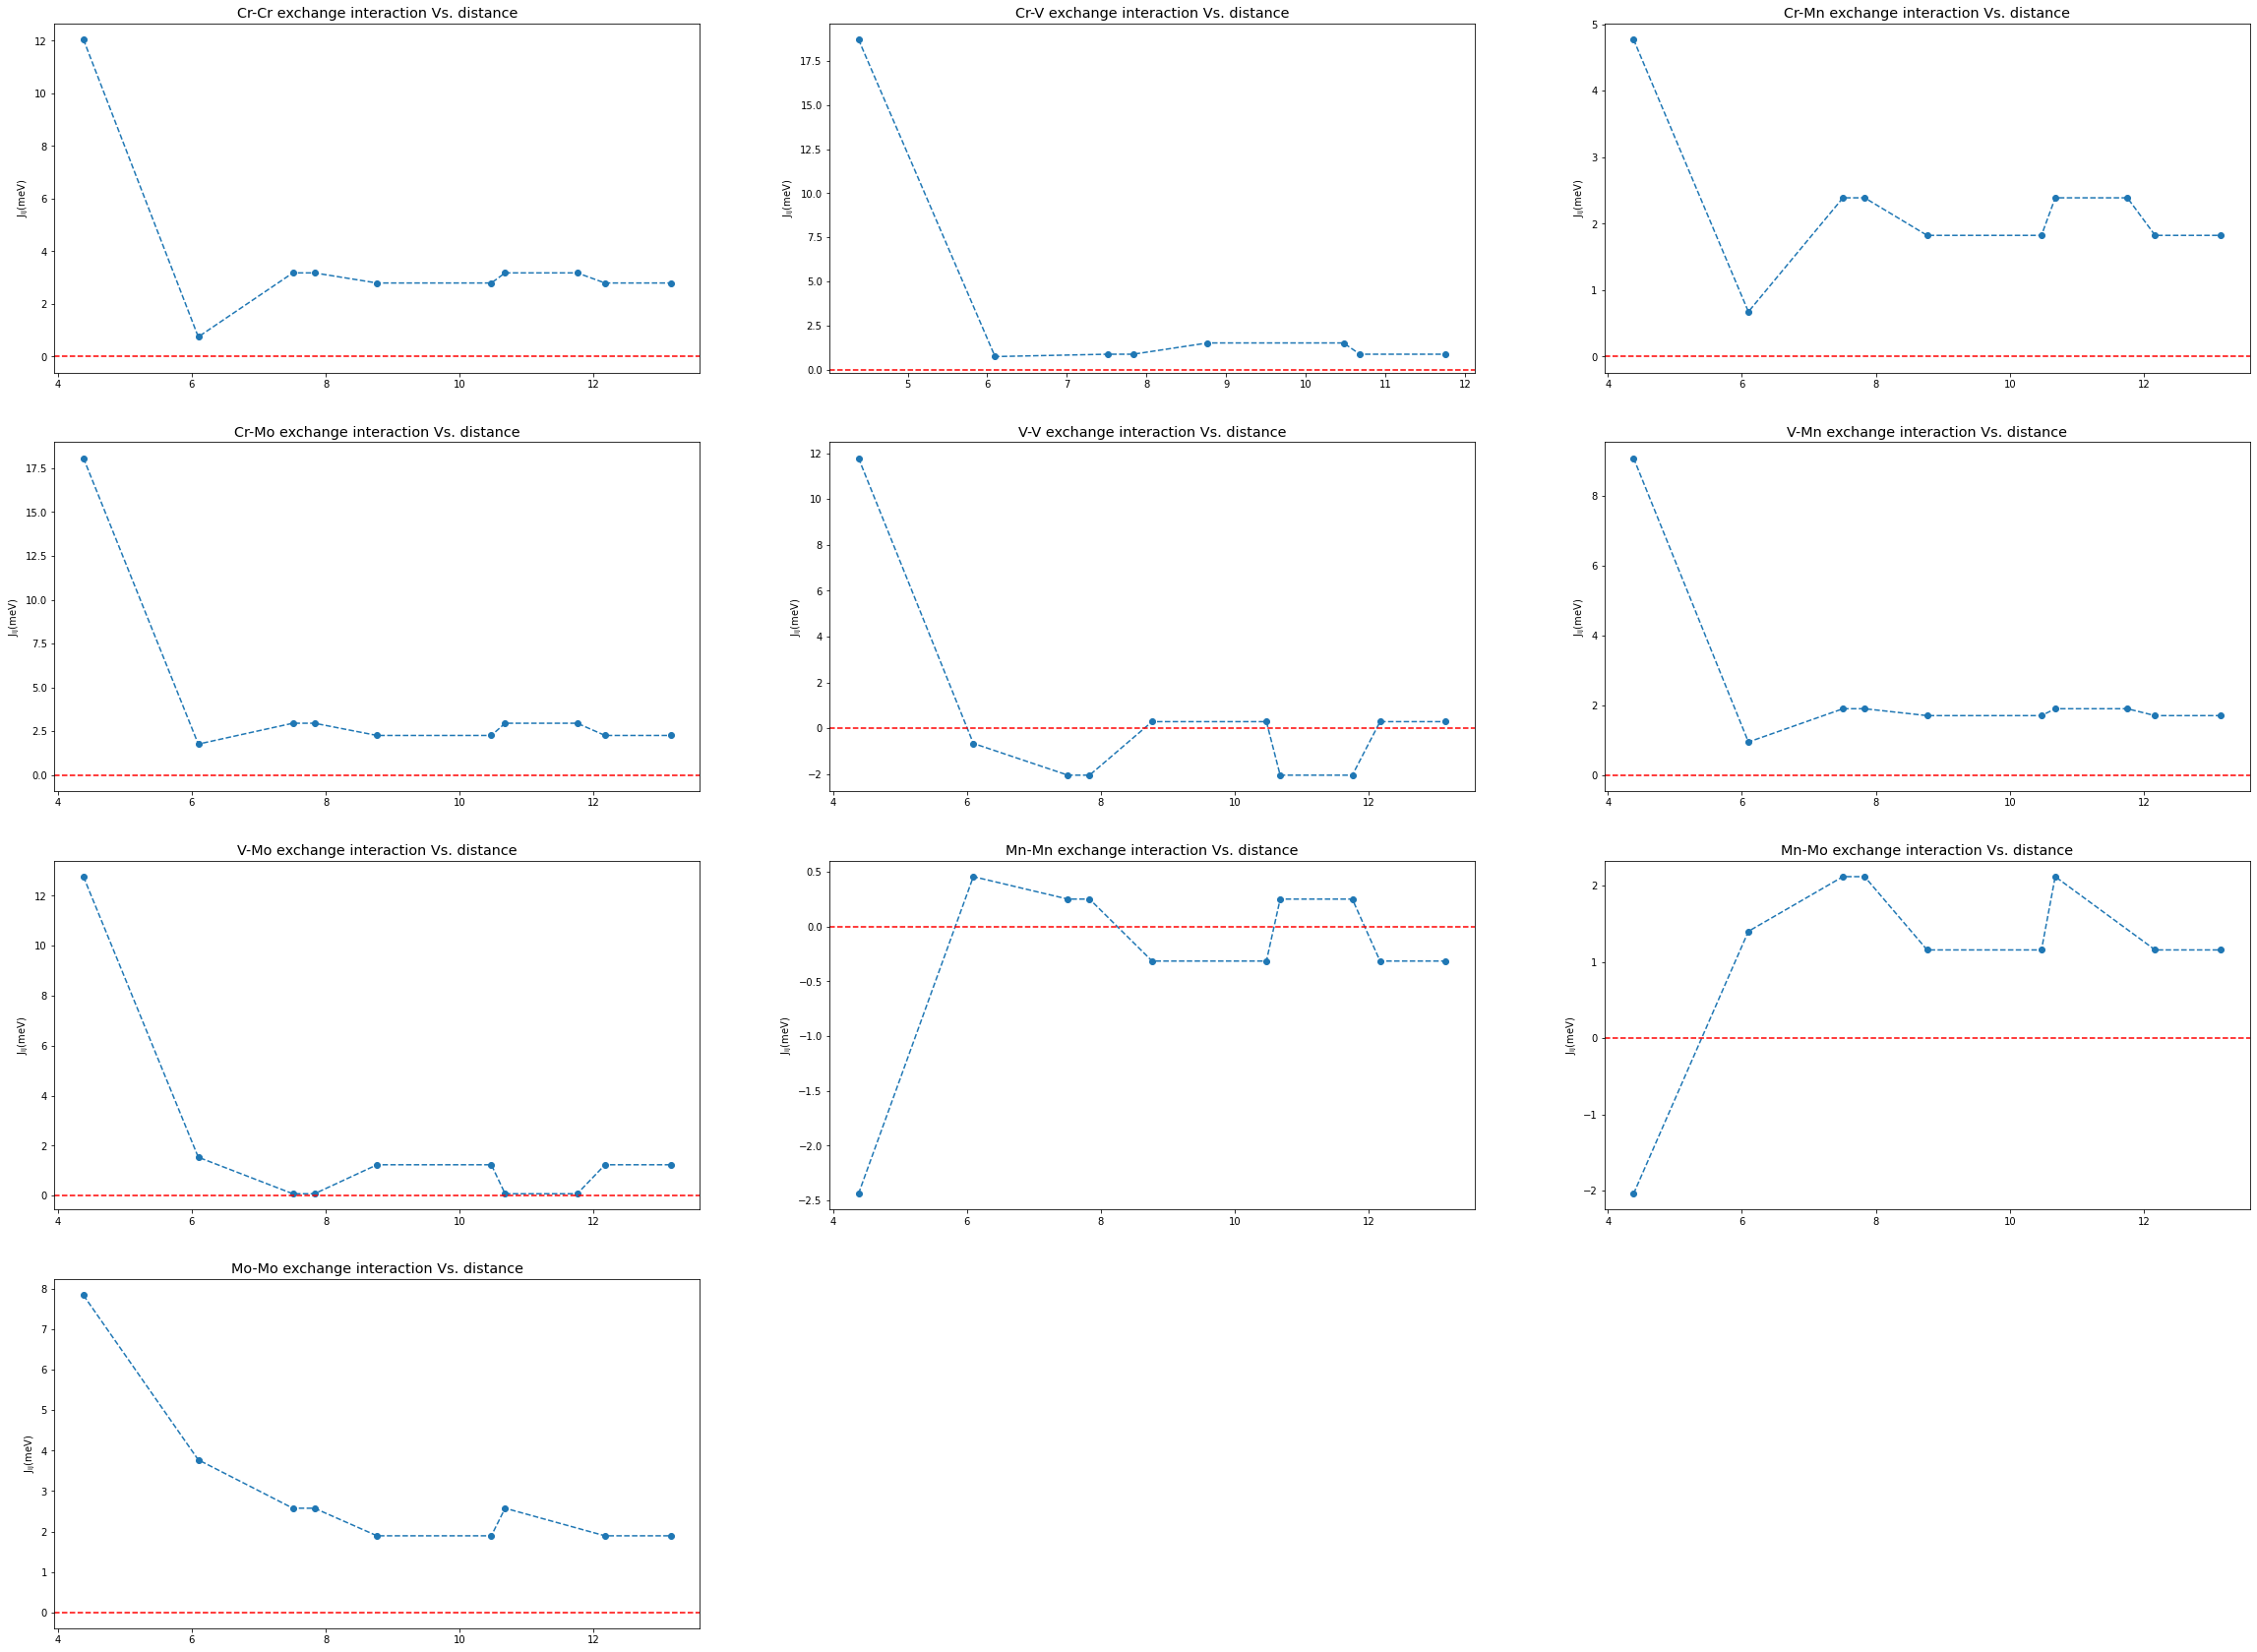

In [154]:
import pandas as pd
import matplotlib.pyplot as plt

pd_data = pd.read_csv('d_block_magnetic_data.csv')
imp_atom = [[(24, 24),('Cr','Cr')], [(24, 23),('Cr','V')], [(24, 25),('Cr','Mn')], [(24, 42),('Cr','Mo')],
            [(23, 23),('V','V')], [(23, 25),('V','Mn')], [(23, 42),('V','Mo')],
            [(25, 25),('Mn','Mn')], [(25, 42),('Mn','Mo')],
            [(42, 42),('Mo','Mo')]]
plt.figure(figsize=(40,30))
x_subplot = 3
y_subplot = 4
dis_unit = 10.4726

for num, Zimp_truple in enumerate(imp_atom):
    imp_atoms = Zimp_truple[0]
    header = list(pd_data.columns)
    z_J_r = pd_data[header[8:10] + [header[10]] + [header[18]]]
    J_Cr_V = z_J_r.loc[(z_J_r['Z_i']==imp_atoms[0]) & (z_J_r['Z_j']==imp_atoms[1])]
    r_vs_J = np.array(J_Cr_V.drop_duplicates().loc[:, ['r', 'J']].sort_values(by='r'))
 #   print(Zimp_truple[1])
 #   print(r_vs_J)
    
    plt.subplot(y_subplot, x_subplot, num+1)
    plt.plot(r_vs_J[:,0]*dis_unit, r_vs_J[:,1], '--o')
    title = (str(Zimp_truple[1][0]) + '-' + str(Zimp_truple[1][1]) + 
            ' exchange interaction Vs. distance')
    plt.title(title, fontsize='x-large')
    plt.axhline(0, ls='--', color= 'red')
    plt.ylabel('$\mathrm{J_{ij}}$(meV)')
    #plt.xlabel()
  #  print(int(num/y_subplot)+1, num%x_subplot+1, num+1)

In [116]:
int(4/3)

1

In [39]:
issubclass(node_group_3_3_1[0].process_class, combine_imps_wc)

True

In [36]:
node_group_3_3_1[0].process_class

aiida_kkr.workflows._combine_imps.combine_imps_wc

In [44]:
combine_imps_wc

aiida_kkr.workflows._combine_imps.combine_imps_wc